In [241]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import statsmodels.api as sm


params = {
    "axes.labelsize": 8, "font.size": 8, "legend.fontsize": 8,
    "xtick.labelsize": 8, "ytick.labelsize": 8, "text.usetex": False,
    "font.family": "sans-serif", "axes.spines.top": False, "axes.spines.right": False,
    "grid.color": "grey", "axes.grid": True,  "grid.alpha": 0.5, "grid.linestyle": ":",
}

plt.rcParams.update(params)

##  Problem 2

In [166]:
data = pd.read_csv("http://www.sfu.ca/~lockhart/richard/Data/FatherSon.txt", delimiter='\t')

In [210]:
F_max = data['Father'].max()
F_min = data['Father'].min()
n_dots = 1000

xs = np.arange(F_min, F_max, (F_max - F_min)/n_dots)

In [239]:
h_values = [0.2,1,2,4]
expected_values = np.zeros([len(h_values), n_dots])


for idx_i, h in enumerate(h_values):
    n_bins = np.round((data['Father'].max() - data['Father'].min()) / h).astype(int)

    bins = pd.cut(data["Father"], bins=n_bins)

    for idx_j, x in enumerate(xs):
        for b in bins:
            if x not in b:
                bin_0 = 0
                continue
            bin_0 = b
            break
        
        if bin_0 == 0:
            continue
        check = lambda x: x in bin_0
        subsample = data['Father'].apply(check)

        expected_values[idx_i, idx_j] = np.mean(data[subsample].Son.values)

In [247]:
# Step 1: Define the dependent and independent variables
X = data['Father']  # Predictor (independent variable)
y = data['Son']     # Outcome (dependent variable)

# Step 2: Add a constant (intercept) to the predictor
X = sm.add_constant(X)

# Step 3: Perform OLS regression
model = sm.OLS(y, X).fit()

x_new = sm.add_constant(xs)
ols_estimate = model.predict(x_new)

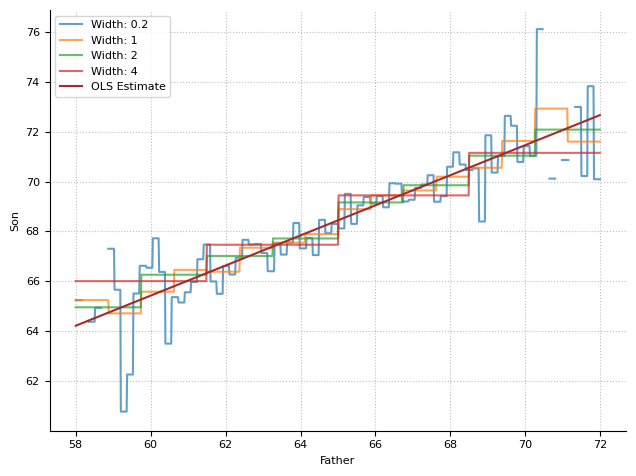

In [305]:
for idx_i in range(len(h_values)):
    expected_values[idx_i,:][expected_values[idx_i,:] == 0] =np.nan
    plt.plot(xs, expected_values[idx_i,:], label = f'Width: {h_values[idx_i]}', alpha = 0.7)


plt.plot(xs, ols_estimate, color = 'brown', label='OLS Estimate')
plt.legend()
plt.xlabel('Father')
plt.ylabel('Son')
plt.tight_layout()
plt.savefig('figs_assignment_2/problem2_1.pdf')
plt.show()

## Problem 3

In [327]:
np.random.seed(42)

size = 20
sample = np.random.uniform(0,1,size=size)

In [328]:
F = stats.ecdf(sample)
t_func = stats.t
n_func = stats.norm

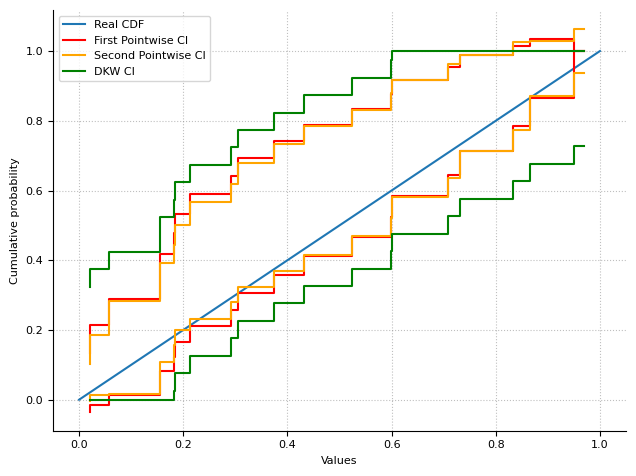

In [329]:
alpha = 0.1

xs = []
ys = []

ci1_low = []
ci1_upp = []

ci2_low = []
ci2_upp = []

ci3_low = []
ci3_upp = []

for x in sorted(sample):
    F_hat = F.cdf.evaluate(x)
    ys.append(F_hat)
    xs.append(x)
    
    t_value = t_func.ppf(alpha/2, df = size)
    n_value = n_func.ppf(alpha/2)
    
    emp_se = np.sqrt(F_hat * (1-F_hat)) / np.sqrt(size)
    se     = np.sqrt(x * (1-x)) / np.sqrt(size)
    
    ci1_low.append(F_hat + t_value * emp_se)
    ci1_upp.append(F_hat - t_value * emp_se)
    
    ci2_low.append(F_hat + n_value * se)
    ci2_upp.append(F_hat - n_value * se)
    
    eps = np.sqrt(1/(2*size) * np.log(2/alpha))
    L = np.max([0, F_hat - eps])
    U = np.min([1, F_hat + eps])
    ci3_low.append(L)
    ci3_upp.append(U)
    
plt.plot([0,1],[0,1], label = 'Real CDF')
plt.step(xs,ci1_low, color = 'red', label = 'First Pointwise CI')
plt.step(xs,ci1_upp, color = 'red')
plt.step(xs,ci2_low, color = 'orange', label = 'Second Pointwise CI')
plt.step(xs,ci2_upp, color = 'orange')
plt.step(xs,ci3_low, color = 'green', label = 'DKW CI')
plt.step(xs,ci3_upp, color = 'green')
plt.ylabel('Cumulative probability')
plt.xlabel('Values')
plt.legend()
plt.tight_layout()
plt.savefig('figs_assignment_2/problem3_1.pdf')
plt.show()

In [333]:
xs = np.array(xs)

samples = []
n = 1000

misses_1 = np.zeros([9])
misses_2 = np.zeros([9])

for i in range(n):
    additional_sample = np.random.uniform(0,1,size=size)
    F_bis = stats.ecdf(additional_sample)
    idx = 0
    for x in np.arange(0.1,1,0.1):
        value = F_bis.cdf.evaluate(x)
        y_cd = np.argmax(xs[xs < x])

        up = ci1_upp[y_cd]
        low = ci1_low[y_cd]

        if value > up or value < low:
            misses_1[idx] += 1
            
        up = ci2_upp[y_cd]
        low = ci2_low[y_cd]

        if value > up or value < low:
            misses_2[idx] += 1
        
        
        
        idx += 1
    samples.append(additional_sample)

for i in range(9):
    print((n - misses_1[i])/n)
    print((n - misses_2[i])/n)
    print('='*70)

In [334]:
missed_1 = 0
missed_2 = 0
missed_3 = 0

for s in samples:
    m_1 = False
    m_2 = False
    m_3 = False
    for x in np.arange(0.1,1,0.1):
        F_bis = stats.ecdf(s)

        value = F_bis.cdf.evaluate(x)
        y_cd = np.argmax(xs[xs < x])

        up = ci1_upp[y_cd]
        low = ci1_low[y_cd]

        if value > up or value < low:
            m_1 = True
            
        up = ci2_upp[y_cd]
        low = ci2_low[y_cd]

        if value > up or value < low:
            m_2 = True
            
        up = ci3_upp[y_cd]
        low = ci3_low[y_cd]

        if value > up or value < low:
            m_3 = True
        
    if m_1 == True:
        missed_1 += 1
    if m_2 == True:
        missed_2 += 1
    if m_3 == True:
        missed_3 += 1
    
    

print((n - missed_1)/n)
s = np.zeros(n)
s[missed_1+1:] = 1
print(np.std(s)/np.sqrt(n))
print('='*70)
print((n - missed_2)/n)
s = np.zeros(n)
s[missed_2+1:] = 1
print(np.std(s)/np.sqrt(n))
print('='*70)
print((n - missed_3)/n)
s = np.zeros(n)
s[missed_3+1:] = 1
print(np.std(s)/np.sqrt(n))
print('='*70)

missed_1 = 0
missed_2 = 0
missed_3 = 0

for s in samples:
    m_1 = False
    m_2 = False
    m_3 = False
    for x in np.arange(0.1,1,0.01):
        F_bis = stats.ecdf(s)

        value = F_bis.cdf.evaluate(x)
        y_cd = np.argmax(xs[xs < x])

        up = ci1_upp[y_cd]
        low = ci1_low[y_cd]

        if value > up or value < low:
            m_1 = True
            
        up = ci2_upp[y_cd]
        low = ci2_low[y_cd]

        if value > up or value < low:
            m_2 = True
            
        up = ci3_upp[y_cd]
        low = ci3_low[y_cd]

        if value > up or value < low:
            m_3 = True
        
    if m_1 == True:
        missed_1 += 1
    if m_2 == True:
        missed_2 += 1
    if m_3 == True:
        missed_3 += 1
    
    

print((n - missed_1)/n)
s = np.zeros(n)
s[missed_1+1:] = 1
print(np.std(s)/np.sqrt(n))
print('='*70)
print((n - missed_2)/n)
s = np.zeros(n)
s[missed_2+1:] = 1
print(np.std(s)/np.sqrt(n))
print('='*70)
print((n - missed_3)/n)
s = np.zeros(n)
s[missed_3+1:] = 1
print(np.std(s)/np.sqrt(n))
print('='*70)

0.506
0.015810597711661628
0.329
0.014846413708367416
0.927
0.00827792244467173
0.135
0.010772372069326235
0.078
0.00843036179532053
0.842
0.011563693181678594


## Problem 4

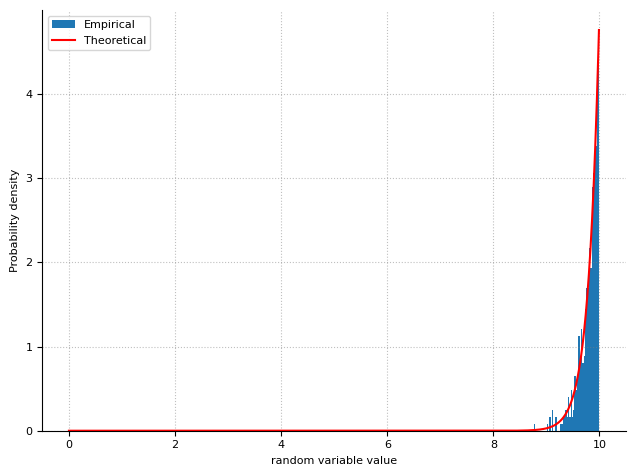

In [344]:
np.random.seed(0)

teta = 10
n = 500
size = 50

estimators = []
samples = []

for idx in range(n):
    sample = np.random.uniform(0,teta, size)
    estimators.append(np.max(sample))
    samples.append(sample)
    
estimators = np.array(estimators)

plt.hist(estimators, density=True, bins = 50, label='Empirical')

density = lambda x: size * x**(size-1)/(teta**size)
xs = np.arange(0,10,10/1000)
ys = density(xs)
plt.plot(xs,ys, color = 'red', label='Theoretical')
plt.xlabel('random variable value')
plt.ylabel('Probability density')
plt.legend()
plt.tight_layout()
plt.savefig('figs_assignment_2/problem4_1.pdf')
plt.show()

In [345]:
qnorm = lambda x: stats.norm.ppf(x)

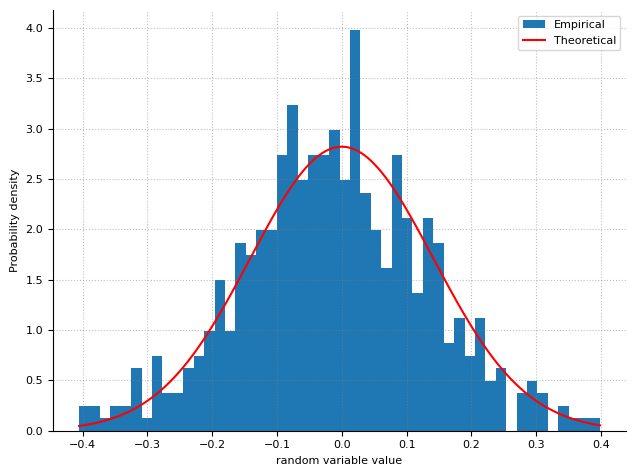

In [346]:
normal_samples = []
means = []

for sample in samples:
    norm_samp = qnorm(sample/10)
    normal_samples.append(norm_samp)
    means.append(np.mean(norm_samp))
    
means = np.array(means)

plt.hist(means, density=True, bins = 50, label='Empirical')
x = np.linspace(np.min(means), np.max(means), 1000)
plt.plot(x, stats.norm.pdf(x, 0, 1/np.sqrt(size)), color = 'red', label='Theoretical')
plt.xlabel('random variable value')
plt.ylabel('Probability density')
plt.legend()
plt.tight_layout()
plt.savefig('figs_assignment_2/problem4_2.pdf')
plt.show()

## Problem 5

In [351]:
mu = 65
sigma = 2.5
e_values = [1,0.1]

low = 58
upp = 72
n_dots = 1000

F = lambda x: stats.norm.cdf(x, loc=mu, scale=sigma)
estimate = lambda x,e: (F(x + e) - F(x - e))/(2 * e)
real     = lambda x: stats.norm.pdf(x, loc=mu, scale=sigma)
bias = lambda x,e: estimate(x,e) - real(x)

xs = np.arange(low, upp, (upp-low)/n_dots)

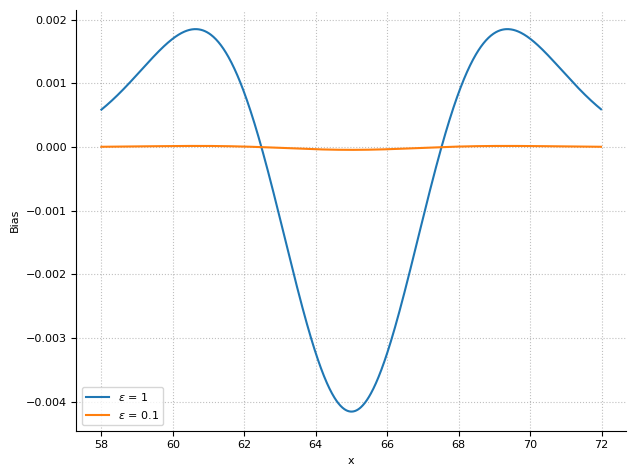

In [355]:
for e in e_values:
    ys = bias(xs,e)
    plt.plot(xs, ys, label=f'$\epsilon$ = {e}')
    
plt.ylabel('Bias')
plt.xlabel('x')
plt.legend()
plt.tight_layout()
plt.savefig('figs_assignment_2/problem5_1.pdf')
plt.show()

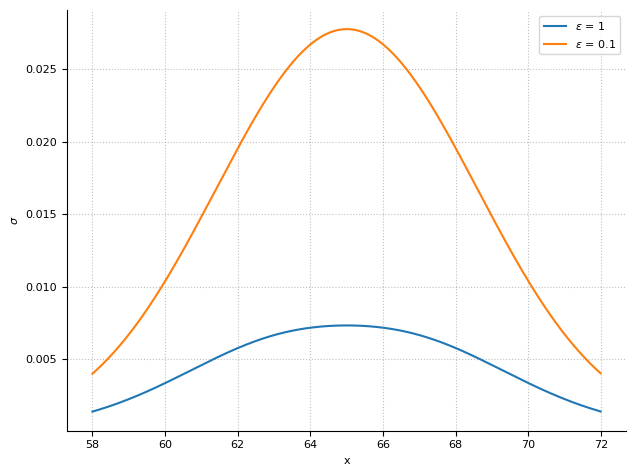

In [356]:
size = 1000
variance = lambda x,e: 1/size * ((F(x+e) - F(x-e))/(4*e**2) - (estimate(x,e))**2 )

for e in e_values:
    ys = variance(xs,e)
    ys = np.sqrt(ys)
    plt.plot(xs, ys, label=f'$\epsilon$ = {e}')
    
plt.ylabel('$\sigma$')
plt.xlabel('x')
plt.legend()
plt.tight_layout()
plt.savefig('figs_assignment_2/problem5_2.pdf')
plt.show()

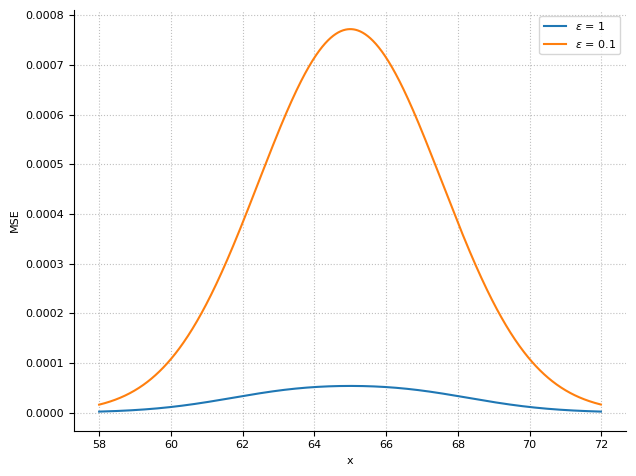

In [357]:
for e in e_values:
    ys = variance(xs,e) + bias(x,e)**2
    plt.plot(xs, ys, label=f'$\epsilon$ = {e}')
    
plt.ylabel('MSE')
plt.xlabel('x')
plt.legend()
plt.tight_layout()
plt.savefig('figs_assignment_2/problem5_3.pdf')
plt.show()